# Configure Cluster Module Params

This notebook should be used as a test for ensuring correct cluster parameters before cluster processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for cluster module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
from matplotlib import pyplot as plt

from lib.shared.file_utils import get_filename
from lib.cluster.cluster_eval import plot_cell_histogram
from lib.cluster.phate_leiden_clustering import (
    phate_leiden_pipeline,
    plot_phate_leiden_clusters,
)
from lib.cluster.benchmark_clusters import (
    create_cluster_gene_table,
    analyze_differential_features,
    process_interactions,
)
from lib.cluster.scrape_benchmarks import (
    get_uniprot_data,
    get_string_data,
    get_corum_data,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
    ROOT_FP = Path(config["all"]["root_fp"])

## <font color='red'>SET PARAMETERS</font>

### Cluster preprocessing

- `MIN_CELL_CUTOFFS`: Minimum cells for each gene to be used in clusetering analysis. More cells per gene increases confidence, but some dataset types (ex mitotic) may have an inherently low number of cells for a particular perturbation.

In [4]:
MIN_CELL_CUTOFFS = {"mitotic": 0, "interphase": 3, "all": 3}

PERTURBATION_NAME_COL = config["aggregate"]["perturbation_name_col"]

Cell count distribution for: mitotic
Number of genes below cutoff: 0
[]


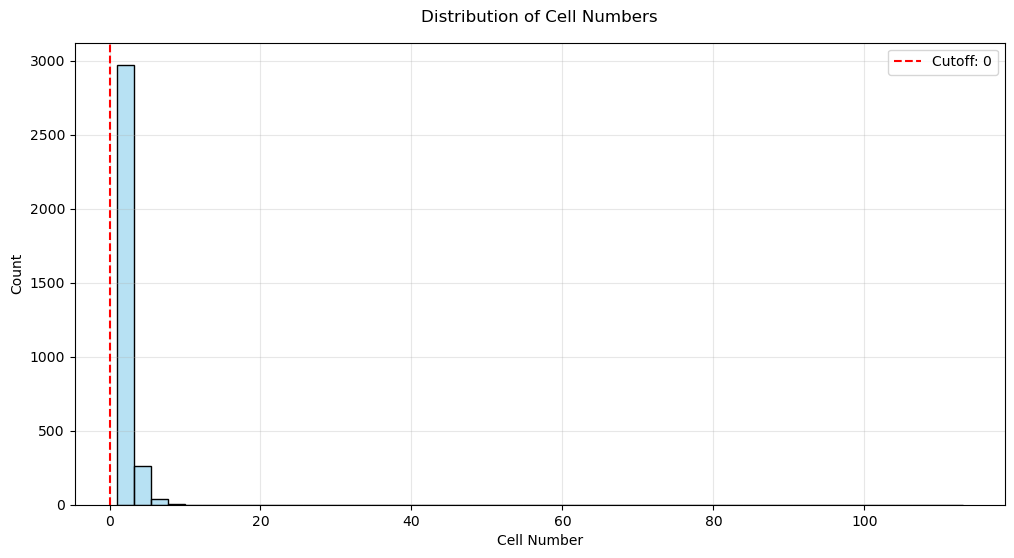

In [5]:
for cell_class, min_cell_cutoff in MIN_CELL_CUTOFFS.items():
    # load and clean relevant dataset
    aggregated_data_path = (
        ROOT_FP
        / "aggregate"
        / "tsvs"
        / get_filename({"cell_class": cell_class}, "aggregated", "tsv")
    )
    aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

    # show cell count distribution
    print(f"Cell count distribution for: {cell_class}")
    plot_cell_histogram(aggregated_data, min_cell_cutoff, PERTURBATION_NAME_COL)
    plt.show()

    break  # TODO: REMOVE

## <font color='red'>SET PARAMETERS</font>

### Cluster Testing

- `TEST_CELL_CLASS`: Cell class to test clustering on. Usually `all` or cell class of interest.

### Phate/Leiden Clustering

- `LEIDEN_RESOLUTION`: Resolution for Leiden clustering. Higher resolution means more clusters.

In [6]:
TEST_CELL_CLASS = "all"
LEIDEN_RESOLUTION = 1

CONTROL_KEY = config["aggregate"]["control_key"]

Calculating PHATE...
  Running PHATE on 5050 observations and 428 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.40 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.36 seconds.
    Calculating affinities...
    Calculated affinities in 1.50 seconds.
  Calculated graph and diffusion operator in 4.32 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.48 seconds.
    Calculating KMeans...
    Calculated KMeans in 11.80 seconds.
  Calculated landmark operator in 16.18 seconds.
  Calculating optimal t...
    Automatically selected t = 3
  Calculated optimal t in 4.39 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.65 seconds.
Calculated PHATE in 30.15 seconds.
Number of clusters: 25
Average cluster size: 202.00


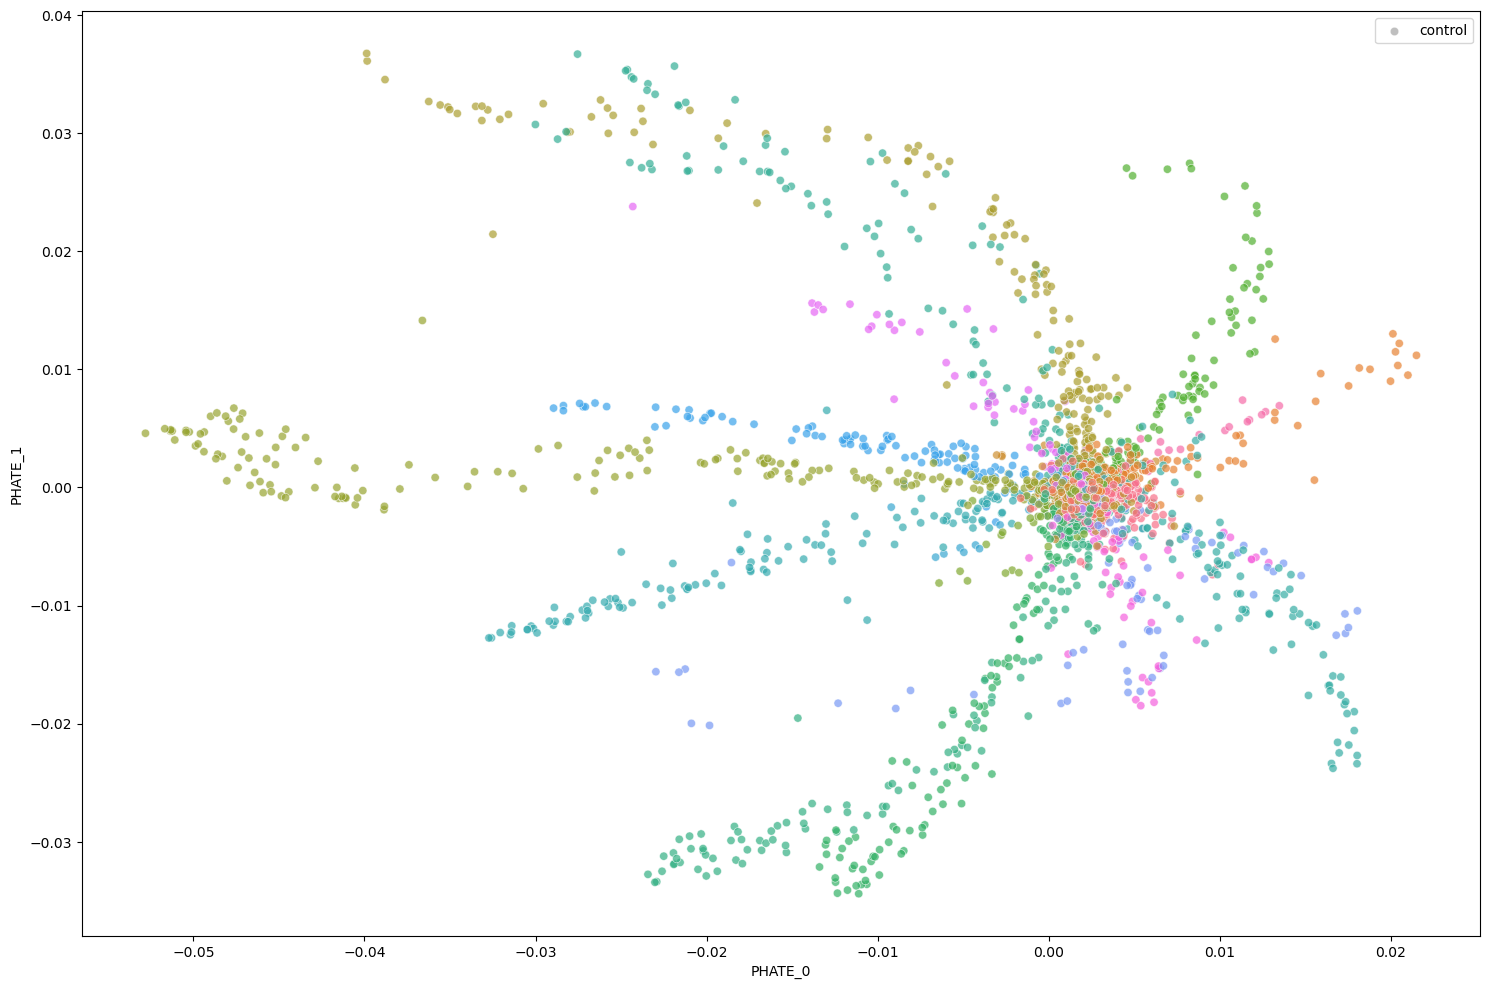

In [7]:
# TODO: update to real paths
# aggregated_data_path = (
#     ROOT_FP
#     / "aggregate"
#     / "tsvs"
#     / get_filename({"cell_class": TEST_CELL_CLASS}, "aggregated", "tsv")
# )
# aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")
aggregated_data_path = "/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/analysis/analysis_root/aggregate/parquets/CC-all__aggregated.parquet"
aggregated_data = pd.read_parquet(aggregated_data_path)

# perform phate leiden clustering
phate_leiden_clustering = phate_leiden_pipeline(
    aggregated_data, resolution=LEIDEN_RESOLUTION
)

plate_leiden_cluster_fig = plot_phate_leiden_clusters(
    phate_leiden_clustering, PERTURBATION_NAME_COL, CONTROL_KEY, figsize=(15, 10)
)

## <font color='red'>SET PARAMETERS</font>

### Cluster Analysis

- `UNIPROT_DATA_FP`: Path to save and access UniProt data with gene descriptions.
- `STRING_DATA_FP`: Path to save and access STRING data with gene pairs.
- `CORUM_DATA_FP`: Path to save and access CORUM data with gene complexes.

In [ ]:
UNIPROT_DATA_FP = "config/benchmark_clusters/uniprot_data.tsv"
STRING_DATA_FP = "config/benchmark_clusters/string_data.tsv"
CORUM_DATA_FP = "config/benchmark_clusters/corum_data.tsv"

In [ ]:
# get and save uniprot data
uniprot_data = get_uniprot_data()
uniprot_data.to_csv(UNIPROT_DATA_FP, sep="\t", index=False)
display(uniprot_data)

# get and save string data
string_data = get_string_data()
string_data.to_csv(STRING_DATA_FP, sep="\t", index=False)
display(string_data)

# get and save corum data
corum_data = get_corum_data()
corum_data.to_csv(CORUM_DATA_FP, sep="\t", index=False)
display(corum_data)

In [ ]:
# load cluster data with uniprot annotations
phate_leiden_uniprot = merge_phate_uniprot(phate_leiden_clustering, UNIPROT_DATA_FP)

# create cluster gene table
cluster_gene_table = create_cluster_gene_table(
    phate_leiden_uniprot,
    columns_to_combine=[POPULATION_FEATURE, "STRING"],
)

# analyze differential features
cluster_gene_table, diff_results = analyze_differential_features(
    cluster_gene_table, cleaned_data
)

# process interactions and get enrichment results
cluster_gene_table, global_metrics = process_interactions(
    cluster_gene_table, STRING_DATA_FP, CORUM_DATA_FP
)

# show cluster analysis results
display(cluster_gene_table)
display(global_metrics)

## Add cluster parameters to config file

In [ ]:
# Add cluster section
config["cluster"] = {
    "min_cell_cutoffs": MIN_CELL_CUTOFFS,
    "leiden_resolution": LEIDEN_RESOLUTION,
    "uniprot_data_fp": UNIPROT_DATA_FP,
    "string_data_fp": STRING_DATA_FP,
    "corum_data_fp": CORUM_DATA_FP,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)